In [1]:
%matplotlib inline

import sympy as sp
sp.init_printing(use_latex ='mathjax')
import scipy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lmfit as lf
import os
import seaborn as sns
from myheatmap import myheatmap
from lmfit import Model
import lmfit
from tabulate import tabulate
import matplotlib

sns.set_context('poster') # makes text larger (poster) or smaller (paper)

In [2]:
## Mac versus PC
mac = False

In [3]:
#Determine amplitude and phase of each resonator for lower and higher frequency modes based on mode map

#Define function to mask mode maps
def maskplot(df, mk, column, uselog=False, cbarlims = None, **kwargs):
    rlogmkname = column + 'logmk'
    rmkname = column + 'mk'
    df[rlogmkname] = np.log10(df[column][mk]) 
    df[rmkname] = df[column][mk]

    if uselog:
        values = rlogmkname
    else:
        values = rmkname
    dfgrid = df.pivot_table(index = 'Green Y', columns = 'Green X', values = values).sort_index(axis = 0, ascending = False)
    ax,cbar = myheatmap(dfgrid, values, return_cbar = True, **kwargs)
    plt.xlabel(u'$x$ (μm)')
    plt.ylabel(u'$y$ (μm)')
    plt.gca().axis('equal')
    return ax, cbar

#Define number of points averaged for amplitude and phase
n_amp = 10
n_phase = 10

In [4]:
"""
openandplotmodemap()

useage:
df, ax1, ax2, cbar1, cbar2 = openandplotmodemap(path)
"""
def openandplotmodemap(path, figsize=(13.23,5), cmap_amp = 'Greys', cmap_phase = 'twilight_shifted', 
                       amp_plot = 'rlog',
                       tenum = u'\u200c            10 μm'):   # tenum is label text for scalebar
    df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2)
    df['w'] = df.frequency * 2 * np.pi

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

    plt.sca(ax1)
    df['rlog'] = np.log10(df.r) 
    amp1 = df.pivot_table(index = 'Green Y', columns = 'Green X', values = amp_plot).sort_index(axis = 0, ascending = False) 
    axx, cbar1 = myheatmap(amp1, amp_plot, cmap = cmap_amp, return_cbar=True); # amp_plot can be 'rlog' or 'r'
    #plt.xlabel(u'$x$ [μm]')
    #plt.ylabel(u'$y$ [μm]')
    ax1.set_title(str(round(df.frequency[0]/1e6,3))+ ' MHz')
    
    # create scalebar
    plt.xlabel('')
    plt.ylabel('')
    ax1.axis('equal')
    topx = amp1.columns.max()
    plt.xticks([topx-10, topx])
    plt.gca().set_xticklabels([tenum, ''])
    plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot


    plt.sca(ax2)
    df['rlog'] = np.log10(df.r) 
    phase1 = df.pivot_table(index = 'Green Y', columns = 'Green X', values = 'phase').sort_index(axis = 0, ascending = False) 
    axx, cbar2 = myheatmap(phase1, 'phase', cmap=cmap_phase,  vmin=-np.pi, vmax=np.pi, return_cbar=True);
    ax2.axis('equal');
    #plt.xlabel(u'$x$ [μm]')
    #plt.ylabel(u'$y$ [μm]')
    ax2.set_title(str(round(df.frequency[0]/1e6,3))+ ' MHz')
    
    # create scalebar
    ax2.axis('equal');
    plt.xlabel('')
    plt.ylabel('')
    topx = phase1.columns.max()
    plt.xticks([topx-10, topx])
    plt.gca().set_xticklabels([tenum, ''])
    plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
    
    ## plot from -pi to pi.
    cbar2.set_ticks([-np.pi,0,np.pi])
    cbar2.ax.set_yticklabels(['$-$\u03C0','0','$+$\u03C0'])  # make sure this line is joined with the one above it.
    
    plt.tight_layout();
    
    return df, ax1, ax2, cbar1, cbar2

\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30\PosGU01ArrayBr0.35p1.4Device0.0Drum1110825
Average amplitude of R1:  1.3940800000000002e-05
Error in amplitude of R1:  9.650075417091603e-08
Average phase of R1:  -1.2045739002000002
Error in phase of R1:  0.008631490507034798
Driving Frequency in rad/s: 55125822.16773502


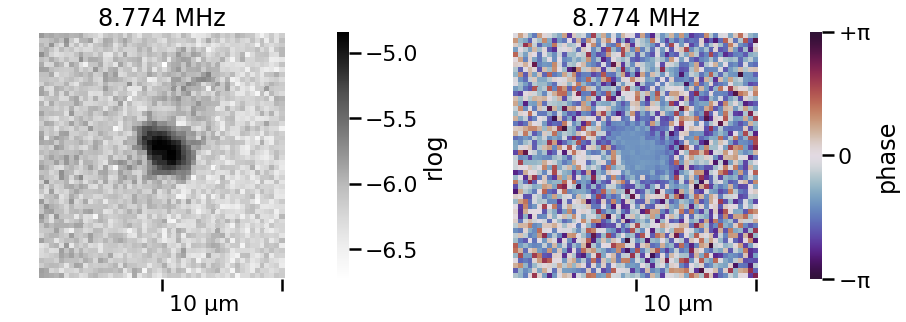

In [5]:
#Plot mode map of first driving frequency

if mac:
    folder1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample 3 2021/2021/09/30/'
else:
    folder1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30'
file1 = 'PosGU01ArrayBr0.35p1.4Device0.0Drum1110825'

path1 = os.path.join(folder1,file1)
print(path1)
df_map1, _, _, _, _ = openandplotmodemap(path1)

#Mask only R1

mkpos1 = df_map1.phase < -0.5

"""fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax1)
maskplot(df_map1, mkpos1, 'r', cmap = 'Greys')

plt.sca(ax2)
maskplot(df_map1, mkpos1, 'phase', cmap = 'twilight_shifted')

plt.tight_layout();"""

#Start table to append driving frequencies, amplitudes and phases
table = [['wDrive', 'Amp', 'Amp Error', 'Rad', 'Rad Error']]

#Assign values to variables
A1 = df_map1[mkpos1].nlargest(n_amp,['r']).r.mean()
p1 = df_map1[mkpos1].nlargest(n_phase,['r']).phase.mean()

A1_error = df_map1[mkpos1].nlargest(n_amp,['r']).r.std() / np.sqrt(n_amp)
p1_error = df_map1[mkpos1].nlargest(n_phase,['r']).phase.std() / np.sqrt(n_phase)

w1 = df_map1.w[1]

#Append info to table
table.append([w1, A1, A1_error, p1, p1_error])

#print the average mean and phase of largest 10 data point amplitudes
print('Average amplitude of R1: ', A1)
print('Error in amplitude of R1: ', A1_error)
print('Average phase of R1: ', p1)
print('Error in phase of R1: ', p1_error)
print('Driving Frequency in rad/s:', w1)

\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30\PosGU01ArrayBr0.35p1.4Device0.0Drum1112334
Low Average amplitude of R1:  1.4710499999999997e-05
Low Average phase of R1:  -2.1001052902
Low Driving Frequency in rad/s: 56183512.7221702


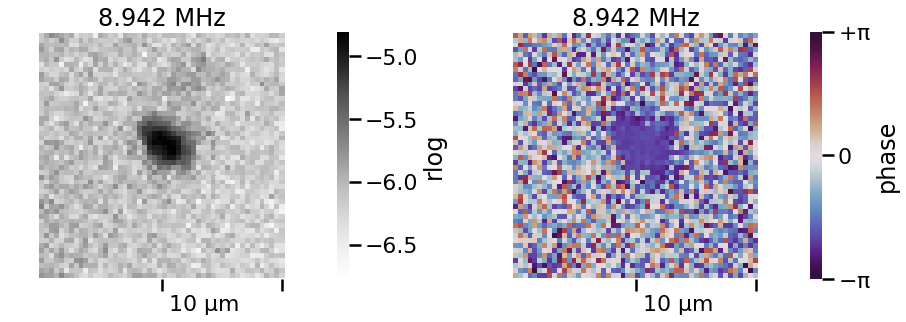

In [6]:
#Plot mode map of second driving frequency

if mac:
    folder2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample 3 2021/2021/09/30/'
else:
    folder2 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30'
file2 = 'PosGU01ArrayBr0.35p1.4Device0.0Drum1112334'

path2 = os.path.join(folder2,file2)
print(path2)
df_map2, _, _, _, _ = openandplotmodemap(path2)

#Mask only R1

mkpos2 = df_map2.phase < -1

"""fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax1)
maskplot(df_map2, mkpos2, 'r', cmap = 'Greys')

plt.sca(ax2)
maskplot(df_map2, mkpos2, 'phase', cmap = 'twilight_shifted')

plt.tight_layout();"""

#Assign values to variables
A2 = df_map2[mkpos2].nlargest(n_amp,['r']).r.mean()
p2 = df_map2[mkpos2].nlargest(n_phase,['r']).phase.mean()

A2_error = df_map2[mkpos2].nlargest(n_amp,['r']).r.std() / np.sqrt(n_amp)
p2_error = df_map2[mkpos2].nlargest(n_phase,['r']).phase.std() / np.sqrt(n_phase)

w2 = df_map2.w[1]

#Append info to table
table.append([w2, A2, A2_error, p2, p2_error])

#print the average mean and phase of largest 10 data point amplitudes
print('Low Average amplitude of R1: ', A2)
print('Low Average phase of R1: ', p2)
print('Low Driving Frequency in rad/s:', w2)

\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30\PosGU01ArrayBr0.35p1.4Device0.0Drum1111328
Low Average amplitude of R1:  1.75655e-05
Low Average phase of R1:  1.1672305597000001
Low Driving Frequency in rad/s: 57770048.490993805


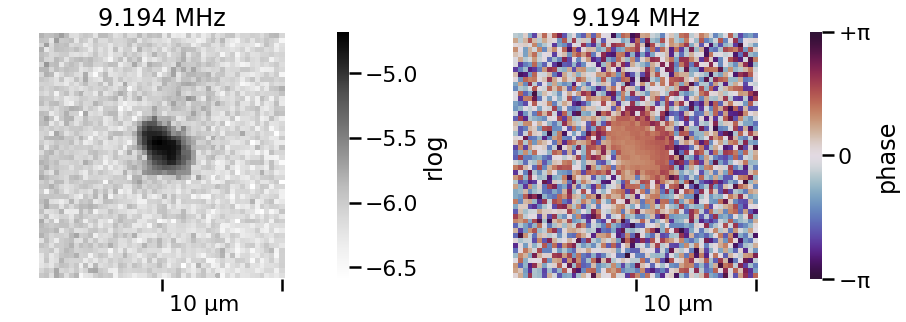

In [7]:
#Plot mode map of third driving frequency

if mac:
    folder3 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample 3 2021/2021/09/30/'
else:
    folder3 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30'
file3 = 'PosGU01ArrayBr0.35p1.4Device0.0Drum1111328'

path3 = os.path.join(folder3,file3)
print(path3)
df_map3, _, _, _, _ = openandplotmodemap(path3)

#Mask only R1

mkpos3 = df_map3.phase > 0.5

"""fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax1)
maskplot(df_map3, mkpos3, 'r', cmap = 'Greys')

plt.sca(ax2)
maskplot(df_map3, mkpos3, 'phase', cmap = 'twilight_shifted')

plt.tight_layout();"""

#Assign values to variables
A3 = df_map3[mkpos3].nlargest(n_amp,['r']).r.mean()
p3 = df_map3[mkpos3].nlargest(n_phase,['r']).phase.mean()

A3_error = df_map3[mkpos3].nlargest(n_amp,['r']).r.std() / np.sqrt(n_amp)
p3_error = df_map3[mkpos3].nlargest(n_phase,['r']).phase.std() / np.sqrt(n_phase)

w3 = df_map3.w[1]

#Append info to table
table.append([w3, A3, A3_error, p3, p3_error])

#print the average mean and phase of largest 10 data point amplitudes
print('Low Average amplitude of R1: ', A3)
print('Low Average phase of R1: ', p3)
print('Low Driving Frequency in rad/s:', w3)

\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30\PosGU01ArrayBr0.35p1.4Device0.0Drum1111835
Low Average amplitude of R1:  8.726300000000001e-06
Low Average phase of R1:  0.3078481297
Low Driving Frequency in rad/s: 58651457.24446566


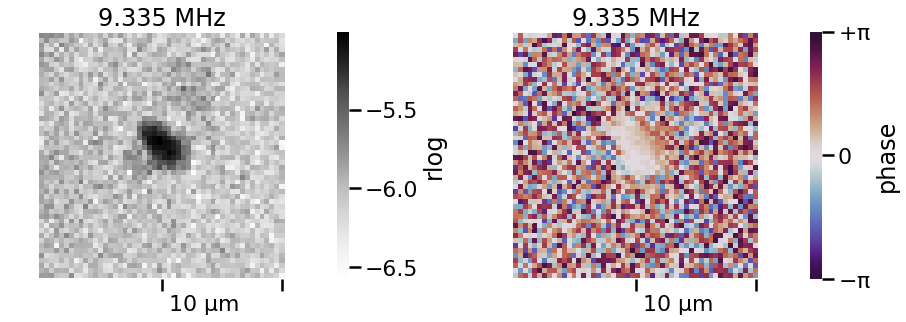

In [8]:
#Plot mode map of fourth driving frequency

if mac:
    folder4 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample 3 2021/2021/09/30/'
else:
    folder4 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\2021\09\30'
file4 = 'PosGU01ArrayBr0.35p1.4Device0.0Drum1111835'

path4 = os.path.join(folder4,file4)
print(path4)
df_map4, _, _, _, _ = openandplotmodemap(path4)

#Mask only R1

mkpos4 = df_map4.phase > 0

"""fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax1)
maskplot(df_map4, mkpos4, 'r', cmap = 'Greys')

plt.sca(ax2)
maskplot(df_map4, mkpos4, 'phase', cmap = 'twilight_shifted')

plt.tight_layout();"""

#Assign values to variables
A4 = df_map4[mkpos4].nlargest(n_amp,['r']).r.mean()
p4 = df_map4[mkpos4].nlargest(n_phase,['r']).phase.mean()

A4_error = df_map4[mkpos4].nlargest(n_amp,['r']).r.std() / np.sqrt(n_amp)
p4_error = df_map4[mkpos4].nlargest(n_phase,['r']).phase.std() / np.sqrt(n_phase)

w4 = df_map4.w[1]

#Append info to table
table.append([w4, A4, A4_error, p4, A4_error])

#print the average mean and phase of largest 10 data point amplitudes
print('Low Average amplitude of R1: ', A4)
print('Low Average phase of R1: ', p4)
print('Low Driving Frequency in rad/s:', w4)

In [9]:
#Convert table to pandas data frame

df_vals = pd.DataFrame(table, columns = table[0])
df_vals = df_vals[1:].reset_index(drop = True)

df_vals

,wDrive,Amp,Amp Error,Rad,Rad Error
0,55125822.167735,0.000014,0.0,-1.204574,0.008631
1,56183512.72217,0.000015,0.0,-2.100105,0.017457
2,57770048.490994,0.000018,0.0,1.167231,0.020721
3,58651457.244466,0.000009,0.0,0.307848,0.0


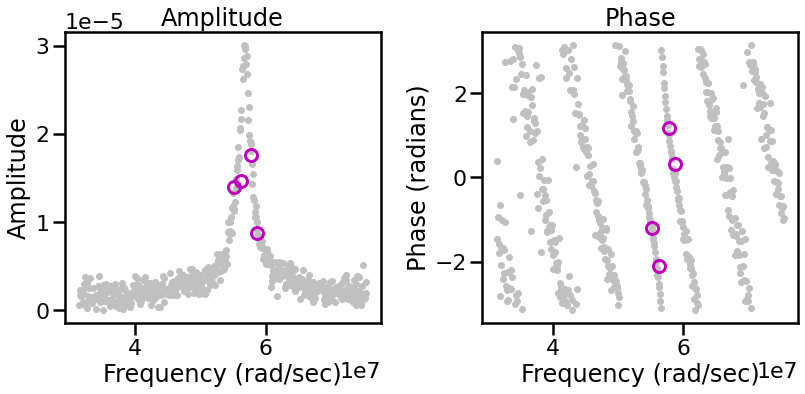

In [10]:
#Import and plot amplitude and phase spectra

sns.set_context('poster')

if mac:
    base = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample 3 2021/Resonance Curves/'
else:
    base = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample 3 2021\Resonance Curves'
path = os.path.join(base, '2021_09_30r0.35p1.4Device0.0Drum1', 'Data.csv')

#Define column names for data frame

colnames = ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']
df = pd.read_csv(path, names = colnames)
df['rad'] = df.theta * np.pi / 180
df['w'] = df.F * 2 * np.pi
df['unwrap'] = np.unwrap(df.rad)

#Plot ampliutde and phase curves"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12,6))

ax1.plot(df.w, df.R, '.', color = 'silver')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude')

for i in range(df_vals.shape[0]):
    ax1.plot(df_vals.wDrive[i], df_vals.Amp[i], 'mo', fillstyle = 'none', markeredgewidth = 3)

ax2.plot(df.w, df.rad, '.', color = 'silver')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Phase')

for i in range(df_vals.shape[0]):
    ax2.plot(df_vals.wDrive[i], df_vals.Rad[i], 'mo', fillstyle = 'none', markeredgewidth = 3)

fig.tight_layout()

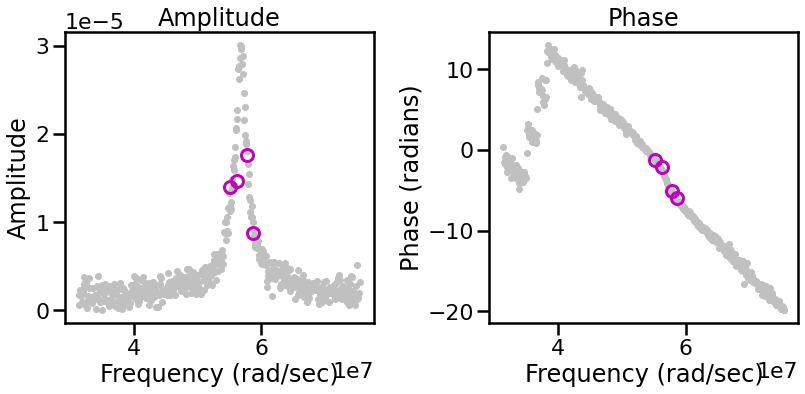

In [11]:
#Plot ampliutde and unwrapped phase curves"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12,6))

ax1.plot(df.w, df.R, '.', color = 'silver')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude')

for i in range(df_vals.shape[0]):
    ax1.plot(df_vals.wDrive[i], df_vals.Amp[i], 'mo', fillstyle = 'none', markeredgewidth = 3)

ax2.plot(df.w, df.unwrap, '.', color = 'silver')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Phase')

for i in range(df_vals.shape[0]):
    ax2.plot(df_vals.wDrive[i], df_vals.Rad[i] % (-2 * np.pi), 'mo', fillstyle = 'none', markeredgewidth = 3)

fig.tight_layout()

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 136
    # variables        = 2
    chi-square         = 27.0340164
    reduced chi-square = 0.20174639
    Akaike info crit   = -215.716016
    Bayesian info crit = -209.890707
[[Variables]]
    slope:     -7.8152e-07 +/- 1.1131e-08 (1.42%) (init = 0)
    intercept:  42.2388409 +/- 0.51349129 (1.22%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.997


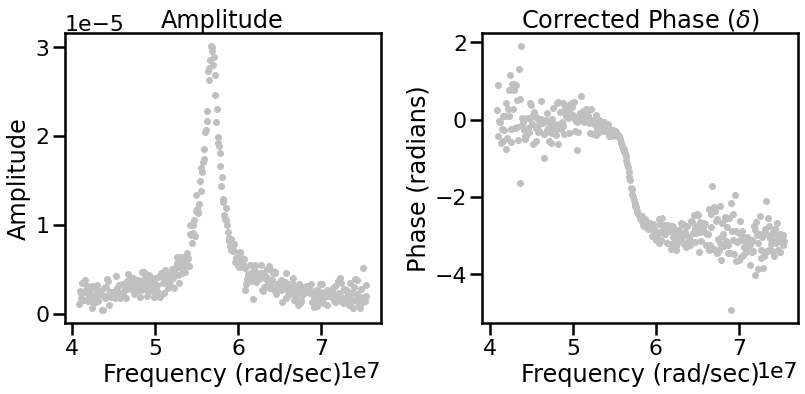

In [12]:
#Correct phase data

#NOTE: If you get error then you might need to adjust the mask bounds

#Fit linear part of phase to flatten
#mk = (df.F < 8*10**6) & (df.F > 6.5*10**6)
mk = (df.w < 5.2*10**7) & (df.w > 4*10**7)
mk2 = df.F > 6.5*10**6

x = df.w[mk]
y = df.unwrap[mk]

#Perform linear fit
model = lmfit.models.LinearModel()
params = model.make_params(intercept = 0, slope = 0)
result = model.fit(y, params, x = x)


#Define linear phase, convert to radians, and unwrap
df['radLin'] = df.unwrap - result.best_values['intercept'] - result.best_values['slope'] * df.w

print(lmfit.fit_report(result))

#Plot ampliutde and phase curves"
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(12,6))

ax1.plot(df.w[mk2], df.R[mk2], '.', color = 'silver')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Amplitude')

#for i in range(df_vals.shape[0]):
    #ax1.plot(df_vals.wDrive[i], df_vals.Amp[i], 'mo', fillstyle = 'none', markeredgewidth = 3)

ax2.plot(df.w[mk2], df.radLin[mk2], '.', color = 'silver')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (radians)')
ax2.set_title('Corrected Phase ($\delta$)')

#for i in range(df_vals.shape[0]):
    #ax2.plot(df_vals.wDrive[i], df_vals.Rad[i], 'mo', fillstyle = 'none', markeredgewidth = 3)

fig.tight_layout()

In [13]:
#Define all variables

k = sp.symbols('k', real = True)
g = sp.symbols('g', real = True)
m = sp.symbols('m', real = True)
F = sp.symbols('F', real = True)

#driving frequency (leave as variable)
wd = sp.symbols('\omega_d', real = True)

#Solve for driving amplitudes and phase

#Matrix for complex equations of motion
driven = sp.Matrix([-wd**2*m + 1j*wd*g + k])

#Matrices for Cramer's Rule
driven_m1 = sp.Matrix([F])

#Apply Cramer's Rule
Cr1 = driven_m1.det()/driven.det()

#Solve for phases for each mass
delta = sp.arg(Cr1)

#Wrap phases for plots
wrap = (delta)%(2*np.pi)

#Solve for amplitude coefficients
amp = sp.sqrt(Cr1*sp.conjugate(Cr1))

#lambdify curves

c1 = sp.lambdify((wd, k, g, F, m), amp)
t1 = sp.lambdify((wd, k, g, F,  m), wrap)

#define functions

def curve1(w, k_, g_,F_, m_):
     return c1(w, k_, g_, F_, m_,)
    
def theta1(w, k_, g_, F_, m_):
     return t1(w, k_, g_, F_, m_) - 2*np.pi

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 97
    # data points      = 786
    # variables        = 4
    chi-square         = 54.1857189
    reduced chi-square = 0.06929120
    Akaike info crit   = -2094.18797
    Bayesian info crit = -2075.52015
[[Variables]]
    Fn:  0.24627237 +/- 14513.6956 (5893351.31%) (init = 4e-07)
    k:   298516.391 +/- 1.4410e+10 (4827059.09%) (init = 0.98)
    g:   13956182.1 +/- 6.7376e+11 (4827673.55%) (init = 3)
    m:   921812.885 +/- 4.4496e+10 (4827047.76%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k, m)  =  1.000
    C(g, m)  =  1.000
    C(k, g)  =  1.000
    C(Fn, g) =  1.000
    C(Fn, k) =  1.000
    C(Fn, m) =  1.000


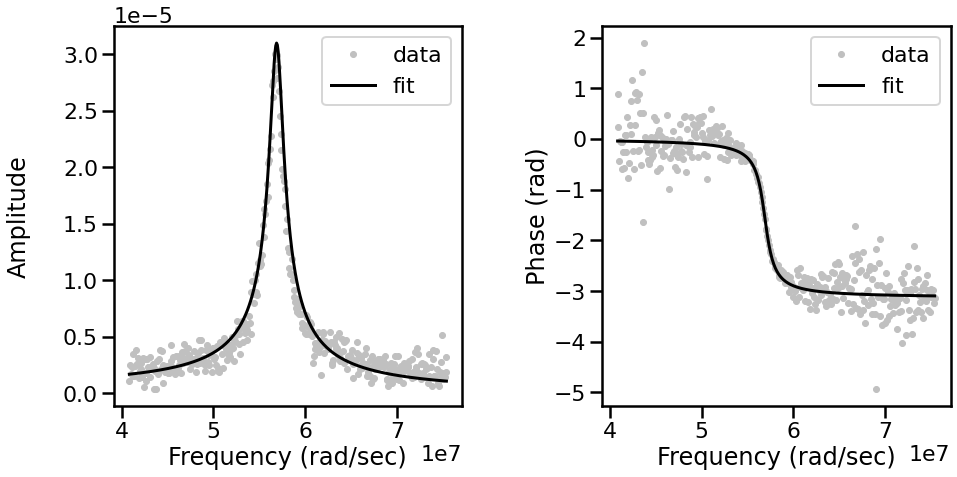

In [14]:
#Fit parameters F, k, g, and m

#Define amplitude function
def volt(w, Fn, k, g, m):
    return Fn/np.sqrt((k-m*10**-16*w**2)**2+(w*g*10**-11)**2)

def phase(w, k, g, m):
     return np.arctan2(-g*10**-11*w, (k-m*10**-16*w**2))
        
#Define input values
x = df.w[mk2].values
y = df.R[mk2].values
p = df.radLin[mk2].values

#Define redisule function
def residual(params, omega, data_amp, data_phase):
    Fn = params['Fn']
    k = params['k']
    g = params['g']
    m = params['m']
    
    model1 = volt(omega, Fn, k, g, m)
    model2 = phase(omega, k, g, m)
    
    resid1 = data_amp - model1
    resid2 = data_phase - model2
    
    return np.concatenate((resid1, resid2))

params = lmfit.Parameters()
params.add('Fn', value = 4*10**-7, min = 0)
params.add('k', value = 0.98, min = 0)
params.add('g', value = 3, min = 0)
params.add('m', value = 1, min = 0)

out = lmfit.minimize(residual, params, args = (x, y, p))

Fn = out.params['Fn'].value
k = out.params['k'].value
g = out.params['g'].value
m = out.params['m'].value

Fn_init = out.params['Fn'].init_value
k_init = out.params['k'].init_value
g_init = out.params['g'].init_value
m_init = out.params['m'].init_value

print(lmfit.fit_report(out))

#Plots for paper

sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,7))

ax1.plot(x, y, '.', color = 'silver')
ax1.plot(x, volt(x, Fn, k, g, m), 'k-')
#ax1.plot(x, volt(x, Fn_init, k_init, g_init, m_init), 'g-')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude\n')
ax1.legend(['data', 'fit', 'guess'])

ax2.plot(x, p, '.', color = 'silver')
ax2.plot(x, phase(x, k, g, m), 'k-')
#ax2.plot(x, phase(x, k_init, g_init, m_init), 'g-')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.legend(['data', 'fit'])

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

In [15]:
#Define function to calculate phase correction and complex amplitudes

phaseCor = []
ampComplex = []

def complexAmp(df, intercept, slope):
    
    #Correct phase with calculated intercept and slope from time delays
    x = df.Rad - (intercept + slope * df.wDrive)
    
    #Add corrected phase to table to append to dataframe
    phaseCor.append(x%(-2*np.pi))
    
    #Use amplitude and corrected phase to calculate complex amplitude
    Z = df.Amp * np.exp(1j * x)
    
    #Add complex amplitude to table to append to dataframe
    ampComplex.append(Z)


for i in range(df_vals.shape[0]):
    complexAmp(df_vals.iloc[i], result.best_values['intercept'], result.best_values['slope']) 
    
df_vals['RadCor'] = np.transpose(phaseCor)
df_vals['ComplexAmp'] = np.transpose(ampComplex)
    
df_vals

#Z1 = 1.4*10**-5 * np.exp(-0.266821j)
#Z2 = 1.6*10**-5 * np.exp(-0.3328j)
#Z3 = 2.1*10**-5 * np.exp(4.18987j)
#Z4 = 1*10**-5 * np.exp(4.07965j)

#w11 = 8.77*2*np.pi*10**6
#w22 = 8.94*2*np.pi*10**6
#w33 = 9.19*2*np.pi*10**6
#w44 = 9.33*2*np.pi*10**6



,wDrive,Amp,Amp Error,Rad,Rad Error,RadCor,ComplexAmp
0,55125822.167735,0.000014,0.0,-1.204574,0.008631,-0.361689,0.000013-0.000005j
1,56183512.72217,0.000015,0.0,-2.100105,0.017457,-0.430618,0.000013-0.000006j
2,57770048.490994,0.000018,0.0,1.167231,0.020721,-2.206564,-0.000010-0.000014j
3,58651457.244466,0.000009,0.0,0.307848,0.0,-2.377111,-0.000006-0.000006j


In [16]:
#Singular Value Decomposition

#Define values for SVD
Z1 = df_vals.ComplexAmp.loc[0]
Z2 = df_vals.ComplexAmp.loc[1]
Z3 = df_vals.ComplexAmp.loc[2]
Z4 = df_vals.ComplexAmp.loc[3]

#Define Matrix M

M = np.array([[-w1**2*np.real(Z1), -w1*np.imag(Z1), np.real(Z1), -1],
             [-w1**2*np.imag(Z1), w1*np.real(Z1), np.imag(Z1), 0],
             [-w2**2*np.real(Z2), -w2*np.imag(Z2), np.real(Z2), -1],
             [-w2**2*np.imag(Z2), w2*np.real(Z2), np.imag(Z2), 0],
             [-w3**2*np.real(Z3), -w3*np.imag(Z3), np.real(Z3), -1],
             [-w3**2*np.imag(Z3), w3*np.real(Z3), np.imag(Z3), 0],
             [-w4**2*np.real(Z4), -w4*np.imag(Z4), np.real(Z4), -1],
             [-w4**2*np.imag(Z4), w4*np.real(Z4), np.imag(Z4), 0]])

#SVD
u, s, vh = np.linalg.svd(M, full_matrices = True)

In [17]:
#Check singular value matrix to see if zero is a singular value
s

array([9.10420317e+10, 1.60167391e+03, 1.63607630e+00, 4.45551013e-07])

In [18]:
vh

array([[ 1.00000000e+00,  0.00000000e+00, -3.09502465e-16,
         3.05762546e-12],
       [ 2.13072867e-15,  9.99999757e-01,  5.77811497e-16,
        -6.96857315e-04],
       [ 3.05762472e-12, -6.96857315e-04,  6.85178750e-07,
        -9.99999757e-01],
       [-3.07407445e-16, -4.77471312e-10, -1.00000000e+00,
        -6.85178584e-07]])

In [19]:
#View vh array and assign variables to proper row vector
vals = [['Normalized Mass', 'Normalized Damping', 'Normalized Spring Constant', 'Normalized Driving Force']]

[M, G, K, FD] = vh[3]

vals.append((M, G, K, FD))

print(tabulate(vals, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒═══════════════════╤══════════════════════╤══════════════════════════════╤════════════════════════════╕
│   Normalized Mass │   Normalized Damping │   Normalized Spring Constant │   Normalized Driving Force │
╞═══════════════════╪══════════════════════╪══════════════════════════════╪════════════════════════════╡
│      -3.07407e-16 │         -4.77471e-10 │                           -1 │               -6.85179e-07 │
╘═══════════════════╧══════════════════════╧══════════════════════════════╧════════════════════════════╛


C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


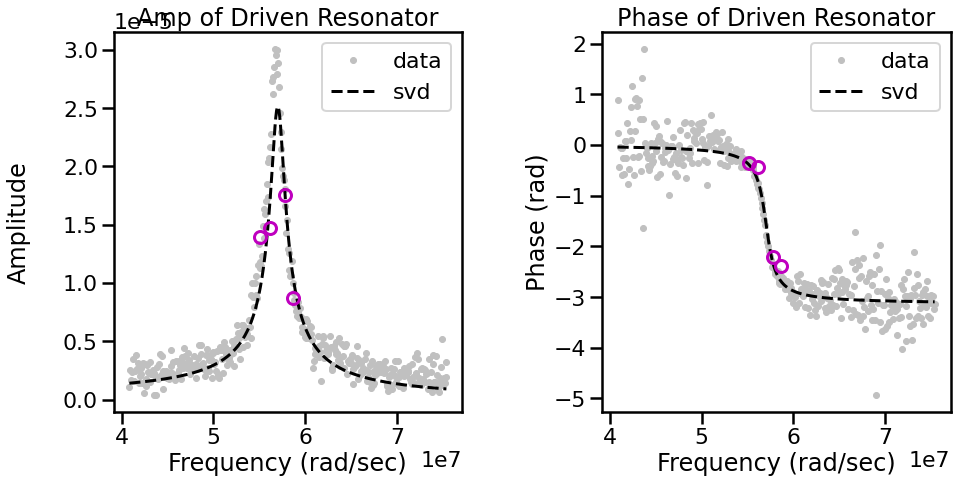

In [20]:
#Plot algebraic approach over spectra

sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,7))

ax1.plot(x, y, '.', color = 'silver')
ax1.plot(x, curve1(x, K, G, FD, M), '--', color = 'black')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Amp of Driven Resonator')
ax1.legend(['data', 'svd'])

for i in range(df_vals.shape[0]):
        ax1.plot(df_vals.wDrive[i], df_vals.Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)

ax2.plot(x, p, '.', color = 'silver')
ax2.plot(x, theta1(x, K, G, FD, M), '--', color = 'black')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Phase of Driven Resonator')
ax2.legend(['data', 'svd'])

for i in range(df_vals.shape[0]):
        ax2.plot(df_vals.wDrive[i], df_vals.RadCor[i], 'mo', fillstyle='none', markeredgewidth = 3)

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

In [21]:
#R^2 value calculation

#Amplitude
Amp_SSres = np.sum((y - curve1(x, K, G, FD, M))**2)
Amp_SStot = np.sum((y - np.mean(y))**2)
Amp_Rsq = 1 - Amp_SSres/Amp_SStot

#Phase
Phase_SSres = np.sum((p - theta1(x, K, G, FD, M))**2)
Phase_SStot = np.sum((p - np.mean(p))**2)
Phase_Rsq = 1 - Phase_SSres/Phase_SStot

print("R-squared value for Amplitude", Amp_Rsq)
print("R-squared value for phase", Phase_Rsq)

R-squared value for Amplitude (0.9170679932259015+0j)
R-squared value for phase 0.9355873809882927


## Error propogation through SVD

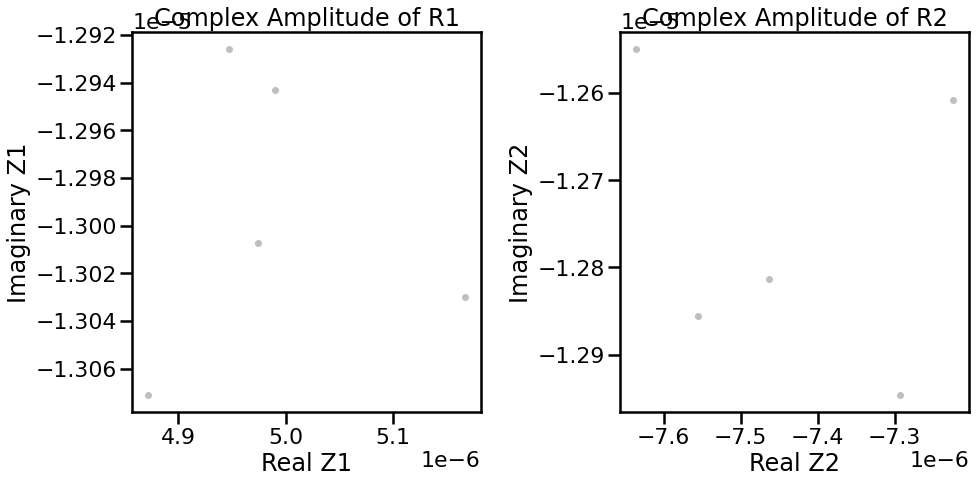

In [22]:
#Define guassian distribution of complex amplitudes

def randomdist(amp_mean, amp_err, phase_mean, phase_err, N, array):
    
    amp_rand = np.random.normal(amp_mean, amp_err, N)
    phase_rand = np.random.normal(phase_mean, phase_err, N)
    
    Z = amp_rand * np.exp(1j * phase_rand)
    
    array.append(Z)
    
    return array

gaussian_Z1 = []
gaussian_Z2 = []

points = 5

randomdist(A1, A1_error, p1, p1_error, points, gaussian_Z1)
randomdist(A2, A2_error, p2, p2_error, points, gaussian_Z2)


sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,7))

ax1.plot(np.real(gaussian_Z1), np.imag(gaussian_Z1), '.', color = 'silver')
ax1.set_xlabel('Real Z1')
ax1.set_ylabel('Imaginary Z1')
ax1.set_title('Complex Amplitude of R1')

ax2.plot(np.real(gaussian_Z2), np.imag(gaussian_Z2), '.', color = 'silver')
ax2.set_xlabel('Real Z2')
ax2.set_ylabel('Imaginary Z2')
ax2.set_title('Complex Amplitude of R2')

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

In [23]:
#Singular Value Decomposition for loop

error_prop = [['Normalized Mass', 'Normalized Damping', 'Normalized Spring Constant', 'Normalized Driving Force']]

for i in range(len(gaussian_Z1[0])):

    Z1 = gaussian_Z1[0][i]
    Z2 = gaussian_Z2[0][i]

    M = np.array([[-w1**2*np.real(Z1), -w1*np.imag(Z1), np.real(Z1), -1],
                 [-w1**2*np.imag(Z1), w1*np.real(Z1), np.imag(Z1), 0],
                 [-w2**2*np.real(Z2), -w2*np.imag(Z2), np.real(Z2), -1],
                 [-w2**2*np.imag(Z2), w2*np.real(Z2), np.imag(Z2), 0],
                 [-w3**2*np.real(Z3), -w3*np.imag(Z3), np.real(Z3), -1],
                 [-w3**2*np.imag(Z3), w3*np.real(Z3), np.imag(Z3), 0],
                 [-w4**2*np.real(Z4), -w4*np.imag(Z4), np.real(Z4), -1],
                 [-w4**2*np.imag(Z4), w4*np.real(Z4), np.imag(Z4), 0]])

    u, s, vh = np.linalg.svd(M, full_matrices = True)
    
    error_prop.append(vh[3])

In [24]:
df_error = pd.DataFrame(error_prop, columns = error_prop[0])
df_error = df_error[1:].reset_index(drop = True)

df_error

,Normalized Mass,Normalized Damping,Normalized Spring Constant,Normalized Driving Force
0,0.0,0.0,1.0,0.000001
1,0.0,0.0,1.0,0.000001
2,0.0,0.0,1.0,0.000001
3,0.0,0.0,1.0,0.000001
4,0.0,0.0,1.0,0.000001


<AxesSubplot:>

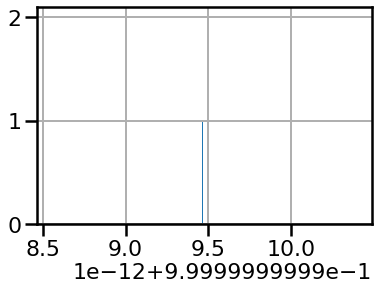

In [25]:
df_error['Normalized Spring Constant'].hist()

<AxesSubplot:>

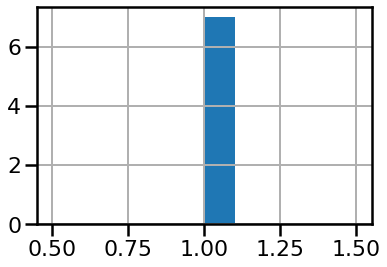

In [26]:
test = pd.DataFrame([1, 1, 1, 1, 1, 1, 1], columns = ['ones'])

test['ones'].hist()

Mass std error 1.7308956780070418e-20
Damping std error 5.816756527230486e-12
Force std error 4.280927125922316e-09
Spring Constant std error 4.420096113598246e-15


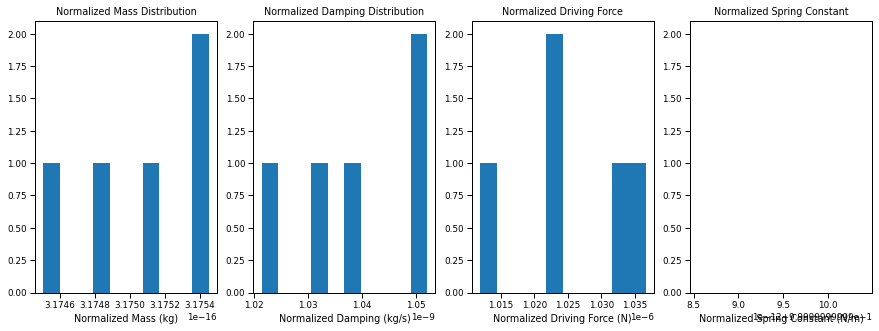

In [27]:
sns.set_context('paper')

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize = (15,5))

ax1.hist(df_error['Normalized Mass'])
ax1.set_xlabel('Normalized Mass (kg)')
ax1.set_title('Normalized Mass Distribution')

ax2.hist(df_error['Normalized Damping'])
ax2.set_xlabel('Normalized Damping (kg/s)')
ax2.set_title('Normalized Damping Distribution')

ax3.hist(df_error['Normalized Driving Force'])
ax3.set_xlabel('Normalized Driving Force (N)')
ax3.set_title('Normalized Driving Force')

ax4.hist(df_error['Normalized Spring Constant'])
ax4.set_xlabel('Normalized Spring Constant (N/m)')
ax4.set_title('Normalized Spring Constant')

print('Mass std error', df_error['Normalized Mass'].std() / np.sqrt(points))
print('Damping std error', df_error['Normalized Damping'].std() / np.sqrt(points))
print('Force std error', df_error['Normalized Driving Force'].std() / np.sqrt(points))
print('Spring Constant std error', df_error['Normalized Spring Constant'].std() / np.sqrt(points))

**Add small angle approximation fudge factor**

In [28]:
#Define Matrix N

N2 = np.array([[-w1**2*np.real(Z1), -w1*np.imag(Z1), np.real(Z1), -1, 0],
             [-w1**2*np.imag(Z1), w1*np.real(Z1), np.imag(Z1), 0, w1],
             [-w2**2*np.real(Z2), -w2*np.imag(Z2), np.real(Z2), -1, 0],
             [-w2**2*np.imag(Z2), w2*np.real(Z2), np.imag(Z2), 0, w1],
             [-w3**2*np.real(Z3), -w3*np.imag(Z3), np.real(Z3), -1, 0],
             [-w3**2*np.imag(Z3), w3*np.real(Z3), np.imag(Z3), 0, w1],
             [-w4**2*np.real(Z4), -w4*np.imag(Z4), np.real(Z4), -1, 0],
             [-w4**2*np.imag(Z4), w4*np.real(Z4), np.imag(Z4), 0, w1]])

#SVD
u2, s2, vh2 = np.linalg.svd(N2, full_matrices = True)

s2

array([9.10900164e+10, 6.45663133e+07, 1.28677838e+03, 9.22599072e-01,
       7.18192612e-07])

In [29]:
vh2

array([[ 9.99999519e-01, -7.29082593e-15, -3.09471841e-16,
        -7.83372457e-12,  9.81094267e-04],
       [ 9.81094267e-04,  1.47908790e-05,  2.80496489e-15,
        -1.52970902e-08, -9.99999519e-01],
       [ 1.45112549e-08, -9.99999497e-01,  1.04465073e-10,
         1.00250921e-03, -1.47908798e-05],
       [-8.29394575e-12, -1.00250921e-03,  1.01703911e-06,
        -9.99999497e-01,  4.69082154e-10],
       [-3.13639105e-16, -1.12405618e-09, -1.00000000e+00,
        -1.01703849e-06, -3.87332297e-15]])

In [30]:
#View vh array and assign variables to proper row vector
vals2 = [['Norm Mass', 'Norm Damping', 'Norm Spring Constant', 'Norm Driving Force', 'Time delay error']]

[M2, G2, K2, FD2, T2] = vh2[4]

vals2.append((M2, G2, K2, FD2, T2))

print(tabulate(vals2, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════╤════════════════╤════════════════════════╤══════════════════════╤════════════════════╕
│    Norm Mass │   Norm Damping │   Norm Spring Constant │   Norm Driving Force │   Time delay error │
╞══════════════╪════════════════╪════════════════════════╪══════════════════════╪════════════════════╡
│ -3.13639e-16 │   -1.12406e-09 │                     -1 │         -1.01704e-06 │       -3.87332e-15 │
╘══════════════╧════════════════╧════════════════════════╧══════════════════════╧════════════════════╛


C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


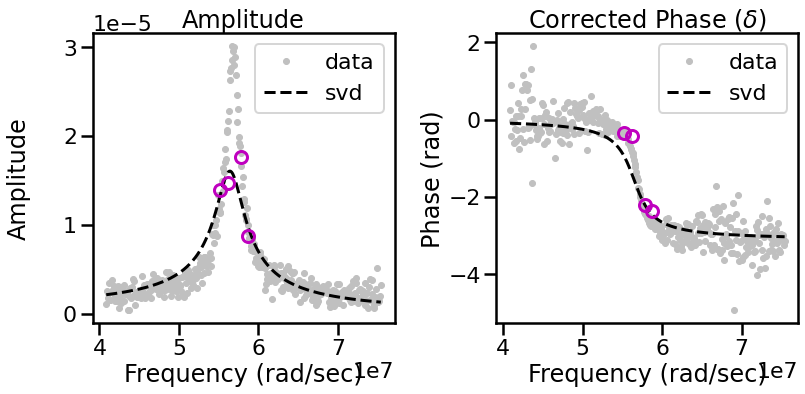

In [31]:
#Plot algebraic approach over spectra

sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (12,6))

ax1.plot(x, y, '.', color = 'silver')
ax1.plot(x, curve1(x, K2, G2, FD2, M2), '--', color = 'black')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Amplitude')
ax1.legend(['data', 'svd'])

for i in range(df_vals.shape[0]):
        ax1.plot(df_vals.wDrive[i], df_vals.Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)

ax2.plot(x, p, '.', color = 'silver')
ax2.plot(x, theta1(x, K2, G2, FD2, M2) + x*T2, '--', color = 'black')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Corrected Phase ($\delta$)')
ax2.legend(['data', 'svd'])

for i in range(df_vals.shape[0]):
        ax2.plot(df_vals.wDrive[i], df_vals.RadCor[i], 'mo', fillstyle='none', markeredgewidth = 3)

#plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

fig.tight_layout()

**Try solving SVD for uncorrected data**

In [32]:
#Define function to calculate complex amplitudes without phase correction

ampComplex2 = []

def complexAmp2(df):
    Z = df.Amp * np.exp(1j * df.Rad)
    ampComplex2.append(Z)


for i in range(df_vals.shape[0]):
    complexAmp2(df_vals.iloc[i]) 
    
df_vals['ComplexAmpUncorrected'] = np.transpose(ampComplex2)
    
df_vals

,wDrive,Amp,Amp Error,Rad,Rad Error,RadCor,ComplexAmp,ComplexAmpUncorrected
0,55125822.167735,0.000014,0.0,-1.204574,0.008631,-0.361689,0.000013-0.000005j,0.000005-0.000013j
1,56183512.72217,0.000015,0.0,-2.100105,0.017457,-0.430618,0.000013-0.000006j,-0.000007-0.000013j
2,57770048.490994,0.000018,0.0,1.167231,0.020721,-2.206564,-0.000010-0.000014j,0.000007+0.000016j
3,58651457.244466,0.000009,0.0,0.307848,0.0,-2.377111,-0.000006-0.000006j,0.000008+0.000003j


In [33]:
#Singular Value Decomposition

#Define values for SVD
Z11 = df_vals.ComplexAmpUncorrected.loc[0]
Z22 = df_vals.ComplexAmpUncorrected.loc[1]
Z33 = df_vals.ComplexAmpUncorrected.loc[2]
Z44 = df_vals.ComplexAmpUncorrected.loc[3]

#Define Matrix M

M3 = np.array([[-w1**2*np.real(Z11), -w1*np.imag(Z11), np.real(Z11), -np.cos(w1*result.best_values['slope'] + result.best_values['intercept'])],
             [-w1**2*np.imag(Z11), w1*np.real(Z11), np.imag(Z11), -np.sin(w1*result.best_values['slope'] + result.best_values['intercept'])],
             [-w2**2*np.real(Z22), -w2*np.imag(Z22), np.real(Z22), -np.cos(w2*result.best_values['slope'] + result.best_values['intercept'])],
             [-w2**2*np.imag(Z22), w2*np.real(Z22), np.imag(Z22), -np.sin(w2*result.best_values['slope'] + result.best_values['intercept'])],
             [-w3**2*np.real(Z33), -w3*np.imag(Z33), np.real(Z33), -np.cos(w3*result.best_values['slope'] + result.best_values['intercept'])],
             [-w3**2*np.imag(Z33), w3*np.real(Z33), np.imag(Z33), -np.sin(w3*result.best_values['slope'] + result.best_values['intercept'])],
             [-w4**2*np.real(Z44), -w4*np.imag(Z44), np.real(Z44), -np.cos(w4*result.best_values['slope'] + result.best_values['intercept'])],
             [-w4**2*np.imag(Z44), w4*np.real(Z44), np.imag(Z44), -np.sin(w4*result.best_values['slope'] + result.best_values['intercept'])]])

#SVD
u3, s3, vh3 = np.linalg.svd(M3, full_matrices = True)

s3

array([9.10420317e+10, 1.60167391e+03, 1.63607630e+00, 4.45551013e-07])

In [34]:
vh3

array([[ 1.00000000e+00,  0.00000000e+00, -3.09502465e-16,
         3.05762546e-12],
       [ 2.13072867e-15,  9.99999757e-01,  5.77892755e-16,
        -6.96857315e-04],
       [ 3.05762472e-12, -6.96857315e-04,  6.85178750e-07,
        -9.99999757e-01],
       [-3.07407445e-16, -4.77471312e-10, -1.00000000e+00,
        -6.85178584e-07]])

In [35]:
#View vh array and assign variables to proper row vector
vals3 = [['Norm Mass', 'Norm Damping', 'Norm Spring Constant', 'Norm Driving Force', 'Time delay error']]

[M3, G3, K3, FD3] = vh3[3]

vals3.append((M3, G3, K3, FD3))

print(tabulate(vals3, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════╤════════════════╤════════════════════════╤══════════════════════╕
│    Norm Mass │   Norm Damping │   Norm Spring Constant │   Norm Driving Force │
╞══════════════╪════════════════╪════════════════════════╪══════════════════════╡
│ -3.07407e-16 │   -4.77471e-10 │                     -1 │         -6.85179e-07 │
╘══════════════╧════════════════╧════════════════════════╧══════════════════════╛


C:\Users\vhorowit\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


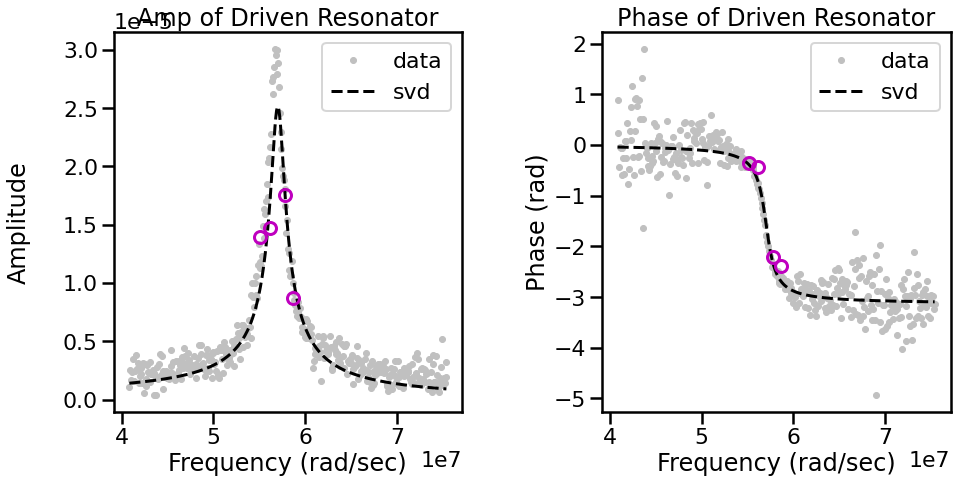

In [36]:
#Plot algebraic approach over spectra

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,7))

ax1.plot(x, y, '.', color = 'silver')
ax1.plot(x, curve1(x, K3, G3, FD3, M3), '--', color = 'black')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude\n')
ax1.set_title('Amp of Driven Resonator')
ax1.legend(['data', 'svd'])

for i in range(df_vals.shape[0]):
        ax1.plot(df_vals.wDrive[i], df_vals.Amp[i], 'mo', fillstyle='none', markeredgewidth = 3)

ax2.plot(x, p, '.', color = 'silver')
ax2.plot(x, theta1(x, K3, G3, FD3, M3), '--', color = 'black')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (rad)')
ax2.set_title('Phase of Driven Resonator')
ax2.legend(['data', 'svd'])

for i in range(df_vals.shape[0]):
        ax2.plot(df_vals.wDrive[i], df_vals.RadCor[i], 'mo', fillstyle='none', markeredgewidth = 3)

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)

**Extra Stuff**

In [37]:
#Fit parameters F, k, g, t

m = 1.6464*10**-16

def volt(w, Fn, k, g):
    return Fn/np.sqrt((k-m*w**2)**2+(w*g*10**-11)**2)

def phase(w, k, g,t):
     return np.arctan2(-g*10**-11*w, (k-m*w**2))-w*t*10**-9
        
#Define input values
x = df.w[mk2].values
y = df.R[mk2].values
p = df.radLin[mk2].values

#Define redisule function
def residual(params, omega, data_amp, data_phase):
    Fn = params['Fn']
    k = params['k']
    g = params['g']
    t = params['t']
    
    model1 = volt(omega, Fn, k, g)
    model2 = phase(omega, k, g, t)
    
    resid1 = data_amp - model1
    resid2 = data_phase - model2
    
    return np.concatenate((resid1, resid2))

params = lmfit.Parameters()
params.add('Fn', value = 10**-7, min = 0)
params.add('k', value = 1, min = 0)
params.add('g', value = 1, min = 0)
params.add('t', value = 30, min = 0)

out = lmfit.minimize(residual, params, args = (x, y, p))

Fn = out.params['Fn'].value
k = out.params['k'].value
g = out.params['g'].value
t = out.params['t'].value

Fn_init = out.params['Fn'].init_value
k_init = out.params['k'].init_value
g_init = out.params['g'].init_value
t_init = out.params['t'].init_value

print(lmfit.fit_report(out))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 114
    # data points      = 786
    # variables        = 4
    chi-square         = 54.1857193
    reduced chi-square = 0.06929120
    Akaike info crit   = -2094.18797
    Bayesian info crit = -2075.52014
[[Variables]]
    Fn:  4.0896e-07 +/- 7.2705e-04 (177779.64%) (init = 1e-07)
    k:   0.53316059 +/- 0.00102131 (0.19%) (init = 1)
    g:   24.9209565 +/- 1.84268578 (7.39%) (init = 1)
    t:   8.3721e-10 +/- 0.00481327 (574921206.04%) (init = 30)


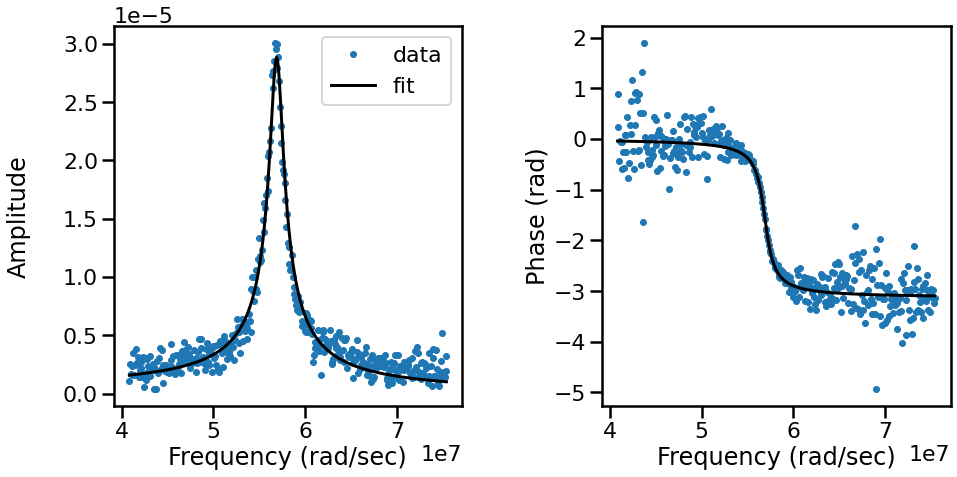

In [38]:
#Plots for paper

sns.set_context('poster')

fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (15,7))

ax1.plot(x, y, '.')
ax1.plot(x, volt(x, Fn, k, g), 'k-')
#ax1.plot(x, volt(x, Fn_init, k_init, g_init, m_init), 'g-')
ax1.set_xlabel('Frequency (rad/sec)')
ax1.set_ylabel('Amplitude\n')
ax1.legend(['data', 'fit', 'guess'])

ax2.plot(x, p, '.')
ax2.plot(x, phase(x, k, g, t), 'k-')
#ax2.plot(x, phase(x, k_init, g_init, m_init), 'g-')
ax2.set_xlabel('Frequency (rad/sec)')
ax2.set_ylabel('Phase (rad)')
#ax2.legend(['data', 'fit', 'guess'])

plt.subplots_adjust(hspace = 0.5, wspace = 0.4)